<h3>Галлямов Артур, КЭ-403, лабораторная работа №4</h3>

1. Разработайте программу, которая выполняет классификацию заданного набора данных с помощью одной из техник ансамблевой классификации. Параметрами программы являются набор данных, ансамблевая техника (бэггинг, случайный лес или бустинг), количество участников ансамбля, а также параметры в соответствии с выбранной техникой ансамблевой классификации.
2. Проведите эксперименты на наборе данных из задания Классификация с помощью дерева решений, варьируя количество участников ансамбля (от 50 до 100 с шагом 10).
3. Выполните визуализацию полученных результатов в виде следующих диаграмм:
* показатели качества классификации в зависимости от количества участников ансамбля для заданного набора данных; нанесите на диаграмму соответствующие значения, полученные в задании Классификация с помощью дерева решений.
4. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
* формулировка задания; 
* гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
* рисунки с результатами визуализации; 
* пояснения, раскрывающие смысл полученных результатов.

<h3>Чтение датасетов и их объединение</h3>

<h3>Импорт необходимых библиотек</h3>

In [1]:
import pandas as pd
import numpy as np
import enum
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

<h3>Чтение датасетов и их объединение</h3>

In [2]:
train = pd.read_csv('train.csv', header=None)
test = pd.read_csv('test.csv', header=None)

column_names = {
    0: "age",
    1: "workclass",
    2: "fnlwgt",
    3: "education",
    4: "education-num",
    5: "marital-status",
    6: "occupation",
    7: "relationship",
    8: "race",
    9: "sex",
    10: "capital-gain",
    11: "capital-loss",
    12: "hours-per-week",
    13: "native-country",
    14: "income"
}

train.rename(columns=column_names, inplace=True)
test.rename(columns=column_names, inplace=True)
test['income'] = test['income'].str.rstrip('.')

dataset = pd.concat([train, test])
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


<h3>Программа ансамблевой классификации</h3>

In [8]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)

    return accuracy, precision

class EnsembleTechnique(enum.Enum):
    RANDOM_FOREST = 'random_forest',
    BAGGING = 'bagging',
    BOOSTING = 'boosting'

def ensemble_classification(dataset, technique:EnsembleTechnique, n_estimators=100, max_depth=15, test_size=0.2):
    encoded_dataset = dataset.copy()
    label_encoder = LabelEncoder()
    for column in encoded_dataset.select_dtypes(include=['object']).columns:
        encoded_dataset[column] = label_encoder.fit_transform(encoded_dataset[column])

    x = encoded_dataset.drop(columns=['income'])
    y = encoded_dataset['income']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    if technique == EnsembleTechnique.RANDOM_FOREST:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif technique == EnsembleTechnique.BAGGING:
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        model = BaggingClassifier(decision_tree, n_estimators=n_estimators, random_state=42)
    elif technique == EnsembleTechnique.BOOSTING:
        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    accuracy, precision = classification_metrics(y_test, y_pred)

    return model, accuracy, precision, x_train, y_train

In [9]:
model, accuracy, precision, X_train, y_train = ensemble_classification(dataset, technique=EnsembleTechnique.RANDOM_FOREST,
                                                                            n_estimators=150, max_depth=15, test_size=0.2)

print(f"Метрики классификации:\n" +
        f"Accuracy: {accuracy:.2f}\n" +
        f"Precision: {precision:.2f}"
      )

Метрики:
Accuracy: 0.86
Precision: 0.80


<h3>Эксперименты на наборе данных из задания "Классификация с помощью дерева решений", с вариацией количества участников ансамбля (от 50 до 100 с шагом 10)</h3>

In [14]:
n_estimators_values = list(range(50, 101, 10))

accuracies = []
precisions = []

# Цикл по значениям количества участников ансамбля
for n_estimators in n_estimators_values:
    # Выполнение классификации для текущего значения количества участников ансамбля
    model, accuracy, precision, x_train, y_train = ensemble_classification(dataset, technique=EnsembleTechnique.RANDOM_FOREST, n_estimators=n_estimators, max_depth=15, test_size=0.2)
    
    accuracies.append(accuracy)
    precisions.append(precision)

print("Результаты экспериментов:")
for n_estimators, accuracy, precision in zip(n_estimators_values, accuracies, precisions):
    print(f"Количество участников = {n_estimators}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")

Результаты экспериментов:
Количество участников = 50:
  Accuracy: 0.8647
  Precision: 0.7980
Количество участников = 60:
  Accuracy: 0.8632
  Precision: 0.7981
Количество участников = 70:
  Accuracy: 0.8630
  Precision: 0.7955
Количество участников = 80:
  Accuracy: 0.8642
  Precision: 0.7995
Количество участников = 90:
  Accuracy: 0.8633
  Precision: 0.7965
Количество участников = 100:
  Accuracy: 0.8640
  Precision: 0.7972


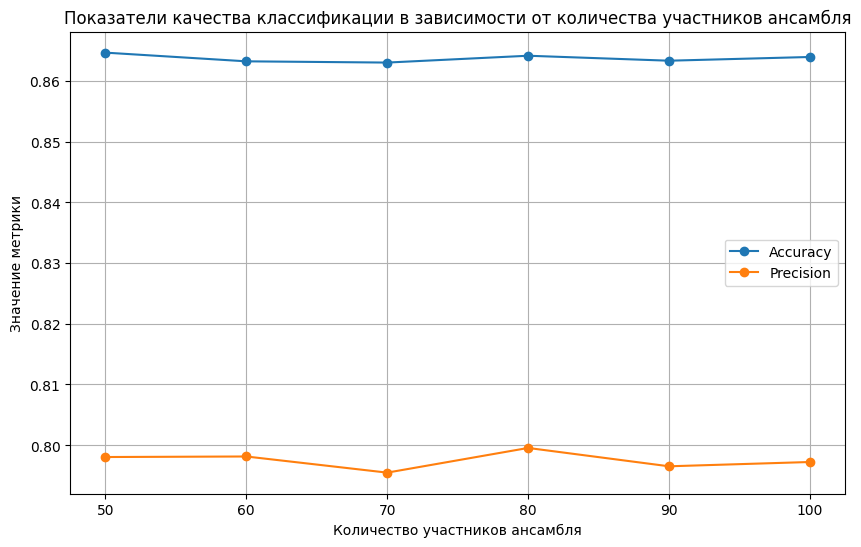

In [13]:
# Графическая настройка
plt.figure(figsize=(10, 6))
plt.title('Показатели качества классификации в зависимости от количества участников ансамбля')
plt.xlabel('Количество участников ансамбля')
plt.ylabel('Значение метрики')

# Построение графиков для каждой метрики
plt.plot(n_estimators_values, accuracies, label='Accuracy', marker='o')
plt.plot(n_estimators_values, precisions, label='Precision', marker='o')

# Добавление легенды
plt.legend()

# Отображение графика
plt.grid(True)
plt.show()